## Introduction


The overall strategy is as follows:

* **Zero:** Merge preprocessed and leaked data
* **First:** Train a Model with normal **LightGBM**
* **Second:** Apply **Feature engineering** and train the **XGB + LightGBM** model at visitor level

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import gc
import time
from pandas.core.common import SettingWithCopyWarning
import warnings
import lightgbm as lgb
from sklearn.model_selection import GroupKFold, GridSearchCV

warnings.simplefilter('error', SettingWithCopyWarning)
warnings.simplefilter("ignore")
gc.enable()
sns.set()
%matplotlib inline

### Fetch the preprocessed data

In [2]:
train = pd.read_csv('data/extracted_fields_train.gz', 
                    dtype={'date': str, 'fullVisitorId': str, 'sessionId':str, "visitId":str}, nrows=None)
test = pd.read_csv('data/extracted_fields_test.gz', 
                   dtype={'date': str, 'fullVisitorId': str, 'sessionId':str, "visitId":str}, nrows=None)
train.shape, test.shape

((903653, 30), (804684, 30))

In [3]:
train.columns

Index(['channelGrouping', 'date', 'fullVisitorId', 'sessionId', 'visitId',
       'visitNumber', 'visitStartTime', 'device.browser',
       'device.deviceCategory', 'device.isMobile', 'device.operatingSystem',
       'geoNetwork.city', 'geoNetwork.continent', 'geoNetwork.country',
       'geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region',
       'geoNetwork.subContinent', 'totals.bounces', 'totals.hits',
       'totals.newVisits', 'totals.pageviews', 'totals.transactionRevenue',
       'trafficSource.adContent', 'trafficSource.campaign',
       'trafficSource.isTrueDirect', 'trafficSource.keyword',
       'trafficSource.medium', 'trafficSource.referralPath',
       'trafficSource.source'],
      dtype='object')

In [4]:
set(train['channelGrouping'])

{'(Other)',
 'Affiliates',
 'Direct',
 'Display',
 'Organic Search',
 'Paid Search',
 'Referral',
 'Social'}

In [5]:
set(train['geoNetwork.subContinent'])

{'(not set)',
 'Australasia',
 'Caribbean',
 'Central America',
 'Central Asia',
 'Eastern Africa',
 'Eastern Asia',
 'Eastern Europe',
 'Melanesia',
 'Micronesian Region',
 'Middle Africa',
 'Northern Africa',
 'Northern America',
 'Northern Europe',
 'Polynesia',
 'South America',
 'Southeast Asia',
 'Southern Africa',
 'Southern Asia',
 'Southern Europe',
 'Western Africa',
 'Western Asia',
 'Western Europe'}

In [6]:
train['trafficSource.adContent'].isna().sum()

892707

In [7]:
train['totals.transactionRevenue'].isna().sum()

892138

### Join with the leaked data

In [8]:
train_store_1 = pd.read_csv('data/Train_external_data.csv', low_memory=False, skiprows=6, dtype={"Client Id":'str'})
train_store_2 = pd.read_csv('data/Train_external_data_2.csv', low_memory=False, skiprows=6, dtype={"Client Id":'str'})
test_store_1 = pd.read_csv('data/Test_external_data.csv', low_memory=False, skiprows=6, dtype={"Client Id":'str'})
test_store_2 = pd.read_csv('data/Test_external_data_2.csv', low_memory=False, skiprows=6, dtype={"Client Id":'str'})

In [9]:
for df in [train_store_1, train_store_2, test_store_1, test_store_2]:
    df["visitId"] = df["Client Id"].apply(lambda x: x.split('.', 1)[1]).astype(str)

In [10]:
train_exdata = pd.concat([train_store_1, train_store_2], sort=False)
test_exdata = pd.concat([test_store_1, test_store_2], sort=False)

for df in [train, test]:
    df["visitId"] = df["visitId"].apply(lambda x: x.split('.', 1)[0]).astype(str)

# Merge with train/test data
train_new = train.merge(train_exdata, how="left", on="visitId")
test_new = test.merge(test_exdata, how="left", on="visitId")

In [11]:
# Drop Client Id
for df in [train_new, test_new]:
    df.drop("Client Id", 1, inplace=True)

#Cleaning Revenue
for df in [train_new, test_new]:
    df["Revenue"].fillna('$', inplace=True)
    df["Revenue"] = df["Revenue"].apply(lambda x: x.replace('$', '').replace(',', ''))
    df["Revenue"] = pd.to_numeric(df["Revenue"], errors="coerce")
    df["Revenue"].fillna(0.0, inplace=True)

#Imputing NaN
for df in [train_new, test_new]:
    df["Sessions"] = df["Sessions"].fillna(0)
    df["Avg. Session Duration"] = df["Avg. Session Duration"].fillna(0)
    df["Bounce Rate"] = df["Bounce Rate"].fillna(0)
    df["Revenue"] = df["Revenue"].fillna(0)
    df["Transactions"] = df["Transactions"].fillna(0)
    df["Goal Conversion Rate"] = df["Goal Conversion Rate"].fillna(0)
    df['trafficSource.adContent'].fillna('N/A', inplace=True)
    df['trafficSource.isTrueDirect'].fillna('N/A', inplace=True)
    df['trafficSource.referralPath'].fillna('N/A', inplace=True)
    df['trafficSource.keyword'].fillna('N/A', inplace=True)
    df['totals.bounces'].fillna(0.0, inplace=True)
    df['totals.newVisits'].fillna(0.0, inplace=True)
    df['totals.pageviews'].fillna(0.0, inplace=True)

In [12]:
train_new.shape

(903654, 36)

In [13]:
del train
del test
train = train_new
test = test_new
del train_new
del test_new
gc.collect()

7

### Define folds by visitors

In [14]:
def get_folds(df=None, n_splits=5):
    """Returns dataframe indices corresponding to Visitors Group KFold"""
    # Get sorted unique visitors
    unique_vis = np.array(sorted(df['fullVisitorId'].unique()))

    # Get folds
    folds = GroupKFold(n_splits=n_splits)
    fold_ids = []
    ids = np.arange(df.shape[0])
    for trn_vis, val_vis in folds.split(X=unique_vis, y=unique_vis, groups=unique_vis):
        fold_ids.append(
            [
                ids[df['fullVisitorId'].isin(unique_vis[trn_vis])],
                ids[df['fullVisitorId'].isin(unique_vis[val_vis])]
            ]
        )

    return fold_ids

### Define target

In [15]:
y_reg = train['totals.transactionRevenue'].fillna(0)
del train['totals.transactionRevenue']

if 'totals.transactionRevenue' in test.columns:
    del test['totals.transactionRevenue']

### Add date features

In [16]:
for df in [train, test]:
    df['date'] = pd.to_datetime(df['visitStartTime'], unit='s')
    df['sess_date_dow'] = df['date'].dt.dayofweek
    df['sess_date_hours'] = df['date'].dt.hour
    df['sess_date_dom'] = df['date'].dt.day

### Apply feature extraction procedure 

In [17]:
def browser_mapping(x):
    browsers = ['chrome','safari','firefox','internet explorer','edge','opera','coc coc','maxthon','iron']
    if x in browsers:
        return x.lower()
    elif  ('android' in x) or ('samsung' in x) or ('mini' in x) or ('iphone' in x) or ('in-app' in x) or ('playstation' in x):
        return 'mobile browser'
    elif  ('mozilla' in x) or ('chrome' in x) or ('blackberry' in x) or ('nokia' in x) or ('browser' in x) or ('amazon' in x):
        return 'mobile browser'
    elif  ('lunascape' in x) or ('netscape' in x) or ('blackberry' in x) or ('konqueror' in x) or ('puffin' in x) or ('amazon' in x):
        return 'mobile browser'
    elif '(not set)' in x:
        return x
    else:
        return 'others'
    
    
def adcontents_mapping(x):
    if  ('google' in x):
        return 'google'
    elif  ('placement' in x) | ('placememnt' in x):
        return 'placement'
    elif '(not set)' in x or 'nan' in x:
        return x
    elif 'ad' in x:
        return 'ad'
    else:
        return 'others'
    
def source_mapping(x):
    if  ('google' in x):
        return 'google'
    elif  ('youtube' in x):
        return 'youtube'
    elif '(not set)' in x or 'nan' in x:
        return x
    elif 'yahoo' in x:
        return 'yahoo'
    elif 'facebook' in x:
        return 'facebook'
    elif 'reddit' in x:
        return 'reddit'
    elif 'bing' in x:
        return 'bing'
    elif 'quora' in x:
        return 'quora'
    elif 'outlook' in x:
        return 'outlook'
    elif 'linkedin' in x:
        return 'linkedin'
    elif 'pinterest' in x:
        return 'pinterest'
    elif 'ask' in x:
        return 'ask'
    elif 'siliconvalley' in x:
        return 'siliconvalley'
    elif 'lunametrics' in x:
        return 'lunametrics'
    elif 'amazon' in x:
        return 'amazon'
    elif 'mysearch' in x:
        return 'mysearch'
    elif 'qiita' in x:
        return 'qiita'
    elif 'messenger' in x:
        return 'messenger'
    elif 'twitter' in x:
        return 'twitter'
    elif 't.co' in x:
        return 't.co'
    elif 'vk.com' in x:
        return 'vk.com'
    elif 'search' in x:
        return 'search'
    elif 'edu' in x:
        return 'edu'
    elif 'mail' in x:
        return 'mail'
    elif 'ad' in x:
        return 'ad'
    elif 'golang' in x:
        return 'golang'
    elif 'direct' in x:
        return 'direct'
    elif 'dealspotr' in x:
        return 'dealspotr'
    elif 'sashihara' in x:
        return 'sashihara'
    elif 'phandroid' in x:
        return 'phandroid'
    elif 'baidu' in x:
        return 'baidu'
    elif 'mdn' in x:
        return 'mdn'
    elif 'duckduckgo' in x:
        return 'duckduckgo'
    elif 'seroundtable' in x:
        return 'seroundtable'
    elif 'metrics' in x:
        return 'metrics'
    elif 'sogou' in x:
        return 'sogou'
    elif 'businessinsider' in x:
        return 'businessinsider'
    elif 'github' in x:
        return 'github'
    elif 'gophergala' in x:
        return 'gophergala'
    elif 'yandex' in x:
        return 'yandex'
    elif 'msn' in x:
        return 'msn'
    elif 'dfa' in x:
        return 'dfa'
    elif '(not set)' in x:
        return '(not set)'
    elif 'feedly' in x:
        return 'feedly'
    elif 'arstechnica' in x:
        return 'arstechnica'
    elif 'squishable' in x:
        return 'squishable'
    elif 'flipboard' in x:
        return 'flipboard'
    elif 't-online.de' in x:
        return 't-online.de'
    elif 'sm.cn' in x:
        return 'sm.cn'
    elif 'wow' in x:
        return 'wow'
    elif 'baidu' in x:
        return 'baidu'
    elif 'partners' in x:
        return 'partners'
    else:
        return 'others'

train['device.browser'] = train['device.browser'].map(lambda x:browser_mapping(str(x).lower())).astype('str')
train['trafficSource.adContent'] = train['trafficSource.adContent'].map(lambda x:adcontents_mapping(str(x).lower())).astype('str')
train['trafficSource.source'] = train['trafficSource.source'].map(lambda x:source_mapping(str(x).lower())).astype('str')

test['device.browser'] = test['device.browser'].map(lambda x:browser_mapping(str(x).lower())).astype('str')
test['trafficSource.adContent'] = test['trafficSource.adContent'].map(lambda x:adcontents_mapping(str(x).lower())).astype('str')
test['trafficSource.source'] = test['trafficSource.source'].map(lambda x:source_mapping(str(x).lower())).astype('str')

def process_device(data_df):
    print("process device ...")
    data_df['source.country'] = data_df['trafficSource.source'] + '_' + data_df['geoNetwork.country']
    data_df['campaign.medium'] = data_df['trafficSource.campaign'] + '_' + data_df['trafficSource.medium']
    data_df['browser.category'] = data_df['device.browser'] + '_' + data_df['device.deviceCategory']
    data_df['browser.os'] = data_df['device.browser'] + '_' + data_df['device.operatingSystem']
    return data_df

train = process_device(train)
test = process_device(test)

def custom(data):
    print('custom..')
    data['device_deviceCategory_channelGrouping'] = data['device.deviceCategory'] + "_" + data['channelGrouping']
    data['channelGrouping_browser'] = data['device.browser'] + "_" + data['channelGrouping']
    data['channelGrouping_OS'] = data['device.operatingSystem'] + "_" + data['channelGrouping']
    
    for i in ['geoNetwork.city', 'geoNetwork.continent', 'geoNetwork.country','geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region','geoNetwork.subContinent']:
        for j in ['device.browser','device.deviceCategory', 'device.operatingSystem', 'trafficSource.source']:
            data[i + "_" + j] = data[i] + "_" + data[j]
    
    data['content.source'] = data['trafficSource.adContent'] + "_" + data['source.country']
    data['medium.source'] = data['trafficSource.medium'] + "_" + data['source.country']
    return data

train = custom(train)
test = custom(test)

process device ...
process device ...
custom..
custom..


In [18]:
train.shape

(903654, 75)

### Create categorical features list

In [19]:
excluded_features = [
    'date', 'fullVisitorId', 'sessionId', 'totals.transactionRevenue', 
    'visitId', 'visitStartTime'
]

categorical_features = [
    _f for _f in train.columns
    if (_f not in excluded_features) & (train[_f].dtype == 'object')
]

In [20]:
categorical_features

['channelGrouping',
 'device.browser',
 'device.deviceCategory',
 'device.operatingSystem',
 'geoNetwork.city',
 'geoNetwork.continent',
 'geoNetwork.country',
 'geoNetwork.metro',
 'geoNetwork.networkDomain',
 'geoNetwork.region',
 'geoNetwork.subContinent',
 'trafficSource.adContent',
 'trafficSource.campaign',
 'trafficSource.isTrueDirect',
 'trafficSource.keyword',
 'trafficSource.medium',
 'trafficSource.referralPath',
 'trafficSource.source',
 'Avg. Session Duration',
 'Bounce Rate',
 'Goal Conversion Rate',
 'source.country',
 'campaign.medium',
 'browser.category',
 'browser.os',
 'device_deviceCategory_channelGrouping',
 'channelGrouping_browser',
 'channelGrouping_OS',
 'geoNetwork.city_device.browser',
 'geoNetwork.city_device.deviceCategory',
 'geoNetwork.city_device.operatingSystem',
 'geoNetwork.city_trafficSource.source',
 'geoNetwork.continent_device.browser',
 'geoNetwork.continent_device.deviceCategory',
 'geoNetwork.continent_device.operatingSystem',
 'geoNetwork.con

### Factorize categoricals

In [21]:
for f in categorical_features:
    train[f], indexer = pd.factorize(train[f])
    test[f] = indexer.get_indexer(test[f])

In [22]:
train.shape, test.shape

((903654, 75), (804686, 75))

### Set CV-fit model parameters

In [23]:
params={'learning_rate': 0.03,
        'objective':'regression',
        'metric':'rmse',
        'num_leaves': 31,
        'verbose': 1,
        "subsample": 0.99,
        "colsample_bytree": 0.99,
        "random_state":42,
        'max_depth': 15,
        'lambda_l2': 0.02085548700474218,
        'lambda_l1': 0.004107624022751344,
        'bagging_fraction': 0.7934712636944741,
        'feature_fraction': 0.686612409641711,
        'min_child_samples': 21
       }

### Model Training with Kfold Validation LightGBM

In [24]:
warnings.simplefilter(action='ignore', category=FutureWarning)

folds = get_folds(df=train, n_splits=5)

train_features = [_f for _f in train.columns if _f not in excluded_features]

importances = pd.DataFrame()
oof_reg_preds = np.zeros(train.shape[0])
sub_reg_preds = np.zeros(test.shape[0])
for fold_, (trn_, val_) in enumerate(folds):
    print("Fold:",fold_)
    trn_x, trn_y = train[train_features].iloc[trn_], y_reg.iloc[trn_]
    val_x, val_y = train[train_features].iloc[val_], y_reg.iloc[val_]
    reg = lgb.LGBMRegressor(**params,
         n_estimators=1000
    )
    reg.fit(
        trn_x, np.log1p(trn_y),
        eval_set=[(val_x, np.log1p(val_y))],
        early_stopping_rounds=50,
        verbose=100,
        eval_metric='rmse'
    )
    imp_df = pd.DataFrame()
    imp_df['feature'] = train_features
    imp_df['gain'] = reg.booster_.feature_importance(importance_type='gain')
    
    imp_df['fold'] = fold_ + 1
    importances = pd.concat([importances, imp_df], axis=0, sort=False)
    
    oof_reg_preds[val_] = reg.predict(val_x, num_iteration=reg.best_iteration_)
    oof_reg_preds[oof_reg_preds < 0] = 0
    _preds = reg.predict(test[train_features], num_iteration=reg.best_iteration_)
    _preds[_preds < 0] = 0
    sub_reg_preds += np.expm1(_preds) / len(folds)
    
mean_squared_error(np.log1p(y_reg), oof_reg_preds) ** .5

Fold: 0
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 1.63562
[200]	valid_0's rmse: 1.61115
[300]	valid_0's rmse: 1.60647
[400]	valid_0's rmse: 1.60289
[500]	valid_0's rmse: 1.60121
[600]	valid_0's rmse: 1.60007
Early stopping, best iteration is:
[593]	valid_0's rmse: 1.59992
Fold: 1
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 1.61183
[200]	valid_0's rmse: 1.59241
[300]	valid_0's rmse: 1.58942
[400]	valid_0's rmse: 1.58745
[500]	valid_0's rmse: 1.58587
Early stopping, best iteration is:
[524]	valid_0's rmse: 1.5857
Fold: 2
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 1.62852
[200]	valid_0's rmse: 1.60662
[300]	valid_0's rmse: 1.60236
[400]	valid_0's rmse: 1.59902
[500]	valid_0's rmse: 1.59691
[600]	valid_0's rmse: 1.59644
Early stopping, best iteration is:
[599]	valid_0's rmse: 1.59643
Fold: 3
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's 

1.5959335529333285

### Display feature importances

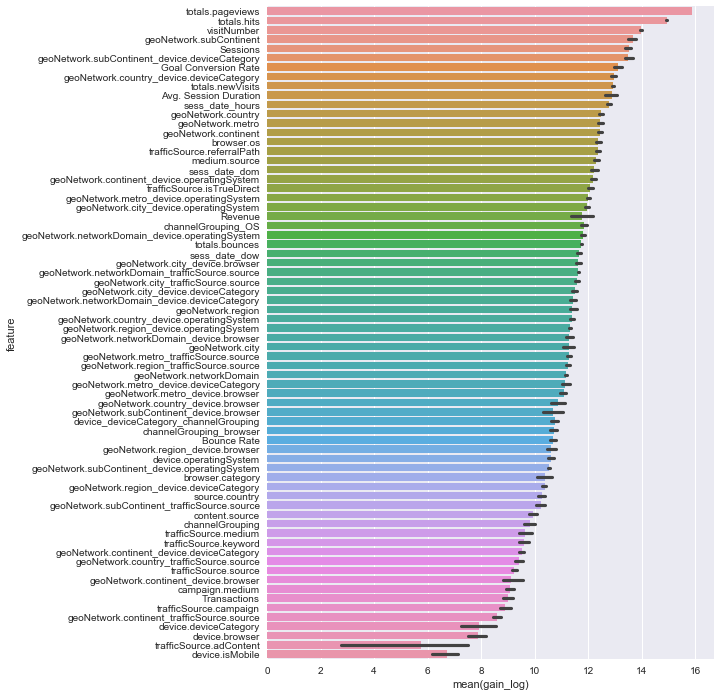

In [25]:
warnings.simplefilter('ignore', FutureWarning)

importances['gain_log'] = np.log1p(importances['gain'])
mean_gain = importances[['gain', 'feature']].groupby('feature').mean()
importances['mean_gain'] = importances['feature'].map(mean_gain['gain'])

plt.figure(figsize=(8, 12))
sns.barplot(x='gain_log', y='feature', data=importances.sort_values('mean_gain', ascending=False))
plt.show()

### Aggregate results of user-level predictions

In [26]:
train['predictions'] = np.expm1(oof_reg_preds)
test['predictions'] = sub_reg_preds

In [27]:
trn_data = train[train_features + ['fullVisitorId']].groupby('fullVisitorId').mean()

In [28]:

# Create a list of predictions for each Visitor
trn_pred_list = train[['fullVisitorId', 'predictions']].groupby('fullVisitorId')\
    .apply(lambda df: list(df.predictions))\
    .apply(lambda x: {'pred_'+str(i): pred for i, pred in enumerate(x)})

In [29]:
trn_pred_list

fullVisitorId
0000010278554503158                                      {'pred_0': 0.0}
0000020424342248747                                      {'pred_0': 0.0}
0000027376579751715                     {'pred_0': 0.011802707346981198}
0000039460501403861                                      {'pred_0': 0.0}
0000040862739425590    {'pred_0': 0.008743737605250929, 'pred_1': 0.0...
000005103959234087                      {'pred_0': 0.034571882002065596}
0000062267706107999                     {'pred_0': 0.001086887989924996}
0000068403966359845                                      {'pred_0': 0.0}
0000085059828173212                                      {'pred_0': 0.0}
0000093957001069502                     {'pred_0': 0.010553760875751278}
0000114156543135683                     {'pred_0': 0.004287481353855068}
0000152474579038632                                      {'pred_0': 0.0}
0000168159078983594                       {'pred_0': 0.7638525498590498}
0000174067426171406        {'pred_0':

In [32]:
trn_all_predictions = pd.DataFrame(list(trn_pred_list.values), index=trn_data.index)
print(trn_all_predictions.head())

                       pred_0    pred_1  pred_10  pred_100  pred_101  \
fullVisitorId                                                          
0000010278554503158  0.000000       NaN      NaN       NaN       NaN   
0000020424342248747  0.000000       NaN      NaN       NaN       NaN   
0000027376579751715  0.011803       NaN      NaN       NaN       NaN   
0000039460501403861  0.000000       NaN      NaN       NaN       NaN   
0000040862739425590  0.008744  0.002907      NaN       NaN       NaN   

                     pred_102  pred_103  pred_104  pred_105  pred_106  \
fullVisitorId                                                           
0000010278554503158       NaN       NaN       NaN       NaN       NaN   
0000020424342248747       NaN       NaN       NaN       NaN       NaN   
0000027376579751715       NaN       NaN       NaN       NaN       NaN   
0000039460501403861       NaN       NaN       NaN       NaN       NaN   
0000040862739425590       NaN       NaN       NaN       N

In [35]:
trn_feats = trn_all_predictions.columns
trn_all_predictions['t_mean'] = np.log1p(trn_all_predictions[trn_feats].mean(axis=1))

In [36]:
trn_all_predictions.head()

,pred_0,pred_1,pred_10,pred_100,pred_101,pred_102,pred_103,pred_104,pred_105,pred_106,...,pred_91,pred_92,pred_93,pred_94,pred_95,pred_96,pred_97,pred_98,pred_99,t_mean
fullVisitorId,,,,,,,,,,,,,,,,,,,,,
0000010278554503158,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
0000020424342248747,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
0000027376579751715,0.011803,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.011734
0000039460501403861,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
0000040862739425590,0.008744,0.002907,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005808


In [108]:

# Create a DataFrame with VisitorId as index
# trn_pred_list contains dict 
# so creating a dataframe from it will expand dict values into columns

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    trn_all_predictions = pd.DataFrame(list(trn_pred_list.values), index=trn_data.index)
    trn_feats = trn_all_predictions.columns
    trn_all_predictions['t_mean'] = np.log1p(trn_all_predictions[trn_feats].mean(axis=1))
    trn_all_predictions['t_median'] = np.log1p(trn_all_predictions[trn_feats].median(axis=1))
    trn_all_predictions['t_sum_log'] = np.log1p(trn_all_predictions[trn_feats]).sum(axis=1)
    trn_all_predictions['t_sum_act'] = np.log1p(trn_all_predictions[trn_feats].fillna(0).sum(axis=1))
    trn_all_predictions['t_nb_sess'] = trn_all_predictions[trn_feats].isnull().sum(axis=1)
    trn_all_predictions.to_csv('trn_all_predictions.csv', index=False)
    full_data = pd.concat([trn_data, trn_all_predictions], axis=1)
    del trn_data, trn_all_predictions
    gc.collect()
    full_data.shape

In [ ]:
full_data.columns

In [30]:
sub_pred_list = test[['fullVisitorId', 'predictions']].groupby('fullVisitorId')\
    .apply(lambda df: list(df.predictions))\
    .apply(lambda x: {'pred_'+str(i): pred for i, pred in enumerate(x)})

In [95]:

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sub_data = test[train_features + ['fullVisitorId']].groupby('fullVisitorId').mean()
    sub_all_predictions = pd.DataFrame(list(sub_pred_list.values), index=sub_data.index)
    for f in trn_feats:
        if f not in sub_all_predictions.columns:
            sub_all_predictions[f] = np.nan
    sub_all_predictions['t_mean'] = np.log1p(sub_all_predictions[trn_feats].mean(axis=1))
    sub_all_predictions['t_median'] = np.log1p(sub_all_predictions[trn_feats].median(axis=1))
    sub_all_predictions['t_sum_log'] = np.log1p(sub_all_predictions[trn_feats]).sum(axis=1)
    sub_all_predictions['t_sum_act'] = np.log1p(sub_all_predictions[trn_feats].fillna(0).sum(axis=1))
    sub_all_predictions['t_nb_sess'] = sub_all_predictions[trn_feats].isnull().sum(axis=1)
    sub_all_predictions.to_csv('sub_all_predictions.csv',index = False)
    sub_full_data = pd.concat([sub_data, sub_all_predictions], axis=1)
    del sub_data, sub_all_predictions
    gc.collect()
    sub_full_data.shape

### Create target and set CV-fit parameters

In [96]:
train['target'] = y_reg
trn_user_target = train[['fullVisitorId', 'target']].groupby('fullVisitorId').sum()

In [97]:

params={'learning_rate': 0.03,
        'objective':'regression',
        'metric':'rmse',
        'num_leaves': 31,
        'verbose': 1,
        "subsample": 0.99,
        "colsample_bytree": 0.99,
        "random_state":42,
        'max_depth': 15,
        'lambda_l2': 0.02085548700474218,
        'lambda_l1': 0.004107624022751344,
        'bagging_fraction': 0.7934712636944741,
        'feature_fraction': 0.686612409641711,
        'min_child_samples': 21
       }

xgb_params = {
        'objective': 'reg:linear',
        'booster': 'gbtree',
        'learning_rate': 0.02,
        'max_depth': 22,
        'min_child_weight': 57,
        'gamma' : 1.45,
        'alpha': 0.0,
        'lambda': 0.0,
        'subsample': 0.67,
        'colsample_bytree': 0.054,
        'colsample_bylevel': 0.50,
        'n_jobs': -1,
        'random_state': 456
    }

### Train the model at Visitor level

In [98]:
warnings.simplefilter(action='ignore', category=FutureWarning)

from xgboost import XGBRegressor
folds = get_folds(df=full_data[['totals.pageviews']].reset_index(), n_splits=5)

oof_preds = np.zeros(full_data.shape[0])
sub_preds = np.zeros(sub_full_data.shape[0])
vis_importances = pd.DataFrame()

for fold_, (trn_, val_) in enumerate(folds):
    trn_x, trn_y = full_data.iloc[trn_], trn_user_target['target'].iloc[trn_]
    val_x, val_y = full_data.iloc[val_], trn_user_target['target'].iloc[val_]
    
    xg = XGBRegressor(**xgb_params, n_estimators=1000)
    
    reg = lgb.LGBMRegressor(**params,
        n_estimators=1500,
    )
    
    xg.fit(
        trn_x, np.log1p(trn_y),
        eval_set=[(trn_x, np.log1p(trn_y)), (val_x, np.log1p(val_y))],
        early_stopping_rounds=50,
        eval_metric='rmse',
        verbose=100
    )
    
    reg.fit(
        trn_x, np.log1p(trn_y),
        eval_set=[(trn_x, np.log1p(trn_y)), (val_x, np.log1p(val_y))],
        eval_names=['TRAIN', 'VALID'],
        early_stopping_rounds=50,
        eval_metric='rmse',
        verbose=100
    )
    
    imp_df = pd.DataFrame()
    imp_df['feature'] = trn_x.columns
    imp_df['gain'] = reg.booster_.feature_importance(importance_type='gain')
    
    imp_df['fold'] = fold_ + 1
    vis_importances = pd.concat([vis_importances, imp_df], axis=0, sort=False)
    
    oof_preds[val_] = reg.predict(val_x, num_iteration=reg.best_iteration_)
    oof_preds[oof_preds < 0] = 0
    
    # Make sure features are in the same order
    _preds = reg.predict(sub_full_data[full_data.columns], num_iteration=reg.best_iteration_)
    _preds[_preds < 0] = 0
    
    pre = xg.predict(sub_full_data[full_data.columns])
    pre[pre<0]=0
    
    sub_preds += (_preds / len(folds)) * 0.6 + (pre / len(folds)) * 0.4
    
mean_squared_error(np.log1p(trn_user_target['target']), oof_preds) ** .5

[0]	validation_0-rmse:2.11019	validation_1-rmse:2.11022
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[100]	validation_0-rmse:1.67104	validation_1-rmse:1.68461
[200]	validation_0-rmse:1.54735	validation_1-rmse:1.57196
[300]	validation_0-rmse:1.48333	validation_1-rmse:1.52418
[400]	validation_0-rmse:1.44976	validation_1-rmse:1.50743
[500]	validation_0-rmse:1.42962	validation_1-rmse:1.50257
[600]	validation_0-rmse:1.41205	validation_1-rmse:1.50052
[700]	validation_0-rmse:1.39897	validation_1-rmse:1.49989
[800]	validation_0-rmse:1.38659	validation_1-rmse:1.49951
Stopping. Best iteration:
[794]	validation_0-rmse:1.38739	validation_1-rmse:1.49947

Training until validation scores don't improve for 50 rounds.
[100]	TRAIN's rmse: 1.4583	VALID's rmse: 1.48938
[200]	TRAIN's rmse: 1.4221	VALID's rmse: 1.48646
Early stopping, best iteration is:
[185]	TRAIN's rmse: 1.42565	VALID's rmse:

KeyboardInterrupt: 

In [ ]:
XGBRegressor()

### Display feature importances

In [ ]:
vis_importances['gain_log'] = np.log1p(vis_importances['gain'])
mean_gain = vis_importances[['gain', 'feature']].groupby('feature').mean()
vis_importances['mean_gain'] = vis_importances['feature'].map(mean_gain['gain'])

plt.figure(figsize=(8, 25))
sns.barplot(x='gain_log', y='feature', data=vis_importances.sort_values('mean_gain', ascending=False).iloc[:300])
plt.show()

### Save Result

In [ ]:
sub_full_data['PredictedLogRevenue'] = sub_preds
sub_full_data[['PredictedLogRevenue']].to_csv('final_sub.csv', index=True)